## TO DO: 
#### Understand what is the source of the perfect training accuracy: 
* Logistic Regression: play on the C parameter
* RF: play on the parameters that can reduce overfitting
#### Features highly correlated with NHY feature:
* NP3FACXP, NP3FTAPR, NP3HMOVR, NP3PRSPR, NP3TTAPR,NP3POSTR, NP3BRADY,NP2TMPR,NP3SPCH,MSEADLG

## REFERENCES

#### NOTEBOOKS - classic ML
* [DSR- Gerrit- intro to ML] (http://localhost:8888/notebooks/00_TRAINING/02_DSR/05_ML_Geritt_Week2/Machine%20Learning%20-%20DSR%20Intro.ipynb)
* [DSR-Gerrit- Boosting & XGBoost]
http://localhost:8888/notebooks/00_TRAINING/02_DSR/05_ML_Geritt_Week2/Boosting%20and%20XGBoost.ipynb
* [DSR-Gerrit- RF]
(http://localhost:8888/notebooks/00_TRAINING/02_DSR/05_ML_Geritt_Week2/%20RF%20notebooks/DecisionTrees_Intro.ipynb)
* [DSR-Gerrit-Evaluation models] (http://localhost:8888/notebooks/00_TRAINING/02_DSR/05_ML_Geritt_Week2/exercises/Evaluation%20Solutions.ipynb)
* [DSR-Gerrit- Bayesian Learning]
(http://localhost:8888/notebooks/00_TRAINING/02_DSR/05_ML_Geritt_Week2/exercises/Bayesian%20Learning%20Solutions.ipynb)
* [DSR-Rachel-ML Pipelines]
(http://localhost:8888/notebooks/00_TRAINING/02_DSR/10_DSR_Model_Pipelines_Rachel/1.3%20Pipelines%20.ipynb)
#### GITHUB repos: 
* **Hands-On Machine Learning w/scikit-learn and TensorFlow book: https://github.com/AMDonati/handson-ml**
* https://github.com/AMDonati/data-science-ipython-notebooks
* Data Science w/ Python handbook: https://github.com/AMDonati/PythonDataScienceHandbook
* https://github.com/AMDonati/machine-learning-cheat-sheet
#### Specific to time-series: 
* https://github.com/ChadFulton/tsa-notebooks
* https://github.com/maxim5/time-series-machine-learning

## 0. Imports & functions

In [1]:
#imports 
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import random
% matplotlib inline

import sklearn
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
import sklearn.cross_validation as cv
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import validation_curve
from sklearn.metrics import confusion_matrix


import warnings
warnings.filterwarnings('ignore')

/Users/alicemartin/miniconda3/envs/project/lib/python3.5/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d
/Users/alicemartin/miniconda3/envs/project/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
!pip install -U imbalanced-learn

Requirement already up-to-date: imbalanced-learn in /Users/alicemartin/miniconda3/envs/project/lib/python3.5/site-packages (0.3.3)


# I. Features importance & Non TS classification of Disease Progression

## 1. Data preparation

In [3]:
file_path='/Users/alicemartin/02_DSR_Project/parkinson-disease-project/output/pre-processing/dfFinal.csv'
df=pd.read_csv(file_path)
df.drop(columns='Unnamed: 0',inplace=True)
df.drop(columns=['EVENT_ID','INFODT'],inplace=True)
#df.set_index(keys=['PATNO'],inplace=True)
df.head()

,PATNO,INFODT_date,NP1COG,NP1HALL,NP1DPRS,NP1ANXS,NP1APAT,NP1DDS,NP2SPCH,NP2SALV,...,DXPOSINS,DXOTHSX,DOMSIDE,num_visits,VISIT_ID,visitsdiff_days,lastDate_diff_days,PDDXDT_diff_days,PDMEDT_diff_days,PDSURGDT_diff_days
0,3001,2011-02-01,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0,0,2,7,1,0,2707,306,0,0
1,3001,2012-03-01,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,...,0,0,2,7,2,394,2313,700,0,0
2,3001,2013-05-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,2,7,3,426,1887,1126,0,0
3,3001,2014-04-01,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0,0,2,7,4,335,1552,1461,0,0
4,3001,2015-04-01,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0,0,2,7,5,365,1187,1826,0,0


In [4]:
dfAgg=df.groupby('PATNO').agg('median')
dfAgg.drop(columns=['visitsdiff_days','VISIT_ID'],inplace=True)
dfAgg.drop(columns='MSEADLG',inplace=True)
dfAgg['NHY']=dfAgg['NHY'].apply(lambda x: round(x,0))
dfAgg.head()

,NP1COG,NP1HALL,NP1DPRS,NP1ANXS,NP1APAT,NP1DDS,NP2SPCH,NP2SALV,NP2SWAL,NP2EAT,...,DXRIGID,DXBRADY,DXPOSINS,DXOTHSX,DOMSIDE,num_visits,lastDate_diff_days,PDDXDT_diff_days,PDMEDT_diff_days,PDSURGDT_diff_days
PATNO,,,,,,,,,,,,,,,,,,,,,
3001,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,2.0,7.0,1552.0,1461.0,0.0,0.0
3002,1.0,0.0,1.0,1.0,0.0,0.0,1.5,2.5,1.0,1.0,...,0.0,1.0,0.0,1.0,1.0,6.0,1567.5,1504.5,0.0,0.0
3003,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,1.0,1.0,...,1.0,1.0,1.0,1.0,2.0,7.0,1552.0,1857.0,0.0,0.0
3006,0.0,0.0,0.5,1.0,0.0,0.0,2.5,0.0,1.0,1.0,...,1.0,1.0,0.0,0.0,2.0,2.0,2465.5,333.5,0.0,0.0
3007,1.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,1.0,...,1.0,1.0,0.0,1.0,2.0,1.0,2648.0,90.0,0.0,0.0


In [5]:
dfAgg['NHY'].value_counts()

2.0    692
0.0    683
1.0    203
3.0     69
4.0     24
5.0      3
Name: NHY, dtype: int64

## 2. Split train, test

In [6]:
from sklearn.model_selection import train_test_split
data=dfAgg.drop(columns='NHY')
target=dfAgg['NHY']
train, test = train_test_split(dfAgg, test_size=0.3, random_state=0)
train.to_pickle("./train_nonTS.pickle")
test.to_pickle("./test_nonTS.pickle")
print('train counts: {}'.format(train.NHY.value_counts()))

X_train = train.loc[:,train.columns!='NHY']
y_train = train['NHY']
X_test = test.loc[:,train.columns!='NHY']
y_test = test[('NHY')]
print(X_train.shape)
print('test counts: {}'.format(y_test.value_counts()))

train.head()

train counts: 0.0    478
2.0    475
1.0    147
3.0     51
4.0     18
5.0      2
Name: NHY, dtype: int64
(1171, 370)
test counts: 2.0    217
0.0    205
1.0     56
3.0     18
4.0      6
5.0      1
Name: NHY, dtype: int64


,NP1COG,NP1HALL,NP1DPRS,NP1ANXS,NP1APAT,NP1DDS,NP2SPCH,NP2SALV,NP2SWAL,NP2EAT,...,DXRIGID,DXBRADY,DXPOSINS,DXOTHSX,DOMSIDE,num_visits,lastDate_diff_days,PDDXDT_diff_days,PDMEDT_diff_days,PDSURGDT_diff_days
PATNO,,,,,,,,,,,,,,,,,,,,,
12898,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1734.0,0.0,0.0,0.0
41544,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2.0,745.5,0.0,0.0,0.0
41284,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,4.0,455.0,0.0,0.0,0.0
53015,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,791.0,0.0,0.0,0.0
4080,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,1.0,1.0,0.0,0.0,2.0,1.0,2099.0,30.0,0.0,0.0


### Take care of the classes unbalance

In [7]:
from sklearn.utils import resample

def upsampling_NHY(train):
    train_majority = train[train.NHY==0.0]
    train_minority_1 = train[train.NHY==1.0]
    train_minority_2= train[train.NHY==2.0]
    train_minority_3= train[train.NHY==3.0]
    train_minority_4=train[train.NHY==4.0]
    train_minority_5=train[train.NHY==5.0]

    # Upsample minority class
    train_minority_upsampled_1 = resample(train_minority_1, 
                                     replace=True,     # sample with replacement
                                     n_samples=train_majority.shape[0],  # to match majority class
                                     random_state=123) # reproducible results
    train_minority_upsampled_2 = resample(train_minority_2, 
                                     replace=True,     # sample with replacement
                                     n_samples=train_majority.shape[0],  # to match majority class
                                     random_state=123) # reproducible results
    train_minority_upsampled_3 = resample(train_minority_3, 
                                     replace=True,     # sample with replacement
                                     n_samples=train_majority.shape[0],  # to match majority class
                                     random_state=123) # reproducible results
    train_minority_upsampled_4= resample(train_minority_4, 
                                     replace=True,     # sample with replacement
                                     n_samples=train_majority.shape[0],  # to match majority class
                                     random_state=123) # reproducible results
    train_minority_upsampled_5= resample(train_minority_5, 
                                     replace=True,     # sample with replacement
                                     n_samples=train_majority.shape[0],  # to match majority class
                                     random_state=123) # reproducible results

    # Combine majority class with upsampled minority class
    train_upsampled = pd.concat([train_majority, train_minority_upsampled_1,train_minority_upsampled_2,
                                 train_minority_upsampled_3,train_minority_upsampled_4,
                                 train_minority_upsampled_5])

    # Show new class counts
    print(train_upsampled.NHY.value_counts())
    
    return train_upsampled

train_upsampled=upsampling_NHY(train)

5.0    478
4.0    478
3.0    478
2.0    478
1.0    478
0.0    478
Name: NHY, dtype: int64


In [8]:
X_train_up = train_upsampled.loc[:,train.columns!='NHY']
y_train_up= train_upsampled['NHY']
data_up=upsampling_NHY(dfAgg)
target_up=data_up['NHY']
data_up.drop(columns='NHY',inplace=True)

5.0    683
4.0    683
3.0    683
2.0    683
1.0    683
0.0    683
Name: NHY, dtype: int64


In [9]:
import sys
sys.version

'3.5.6 |Anaconda, Inc.| (default, Aug 26 2018, 16:30:03) \n[GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]'

from imblearn.over_sampling import SMOTE
X_resampled, y_resampled = SMOTE().fit_sample(X_train, y_train)
X_resampled.shape
logreg_smote = LogisticRegression(random_state=0).fit(X_resampled, y_resampled)

In [10]:
#X_resampled, y_resampled = ADASYN().fit_sample(X, y)
#clf_adasyn = LinearSVC().fit(X_resampled, y_resampled)

## 3. Model Training

### Dummy Classifier

In [11]:
from sklearn.dummy import DummyClassifier
dummy=DummyClassifier()
dummy.fit(X_train, y_train)

DummyClassifier(constant=None, random_state=None, strategy='stratified')

In [12]:
print("Train-Score: %.4f, Test-Accuracy: %.4f" % (dummy.score(X_train, y_train), dummy.score(X_test, y_test)))

Train-Score: 0.3664, Test-Accuracy: 0.3260


### Logistic Regression

In [13]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(multi_class='multinomial',solver='newton-cg',random_state=0)
logreg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=1, penalty='l2', random_state=0, solver='newton-cg',
          tol=0.0001, verbose=0, warm_start=False)

In [14]:
logreg_up=LogisticRegression(multi_class='multinomial',solver='newton-cg',random_state=1)
logreg_up.fit(X_train_up, y_train_up)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=1, penalty='l2', random_state=1, solver='newton-cg',
          tol=0.0001, verbose=0, warm_start=False)

### Random Forest

In [15]:
rfc_up = RandomForestClassifier(n_estimators=100, random_state=1)
rfc_up.fit(X_train_up, y_train_up)

rfc = RandomForestClassifier(n_estimators=100, random_state=0)
rfc.fit(X_train, y_train)

dict_weight={'0.0':0.4, '2.0':0.4, '1.0':0.4/3, '3.0':0.4/9, '4.0':0.4/27, '5.0':0.4/(27*8)}
rfc_weighted = RandomForestClassifier(n_estimators=100, random_state=1,class_weight='balanced')
rfc_weighted.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=1, oob_score=False, random_state=1,
            verbose=0, warm_start=False)

In [16]:
#for estimator in rfc.estimators_:
    #print(estimator.tree_.max_depth)
np.mean([estimator.tree_.max_depth for estimator in rfc.estimators_])

17.92

In [17]:
0.4*2+0.4/3+0.4/9+0.4/27+0.4/(8*27)

0.9944444444444445

In [18]:
0.4/3

0.13333333333333333

### XGBoost

In [19]:
from xgboost import XGBClassifier
xgb = XGBClassifier(n_jobs=-1,seed=0)
xgb.fit(X_train, y_train)
xgb_up=XGBClassifier(n_jobs=-1,seed=0)
xgb_up.fit(X_train_up, y_train_up)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=-1, nthread=None, objective='multi:softprob', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=0, silent=True,
       subsample=1)

### feature importance
do a pairplot of the important features in the original dataset

In [20]:
feature_importances = pd.DataFrame(rfc.feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance']).sort_values('importance',ascending=False)
ImportantFeatures=feature_importances[feature_importances.values>=0.01]
RelevantFeatures=feature_importances[feature_importances.values>0]
RelevantFeaturesList=list(RelevantFeatures.index)
#RelevantFeaturesList
print(sum(ImportantFeatures.values))
print(len(RelevantFeatures)/len(feature_importances))
ImportantFeatures
#plt.plot(list(ImportantFeatures.index),list(ImportantFeatures.values),kind='bar')

[0.59281574]
0.8945945945945946


,importance
DOMSIDE,0.068395
PRIMDIAG,0.050340
PDDXDT_diff_days,0.049499
DFRIGIDP,0.029434
NP3FACXP,0.027966
PD_MED_USE,0.025725
NP3BRADY,0.023187
PDMEDYN,0.021384
DFPGDIST,0.019051
DXBRADY,0.018643


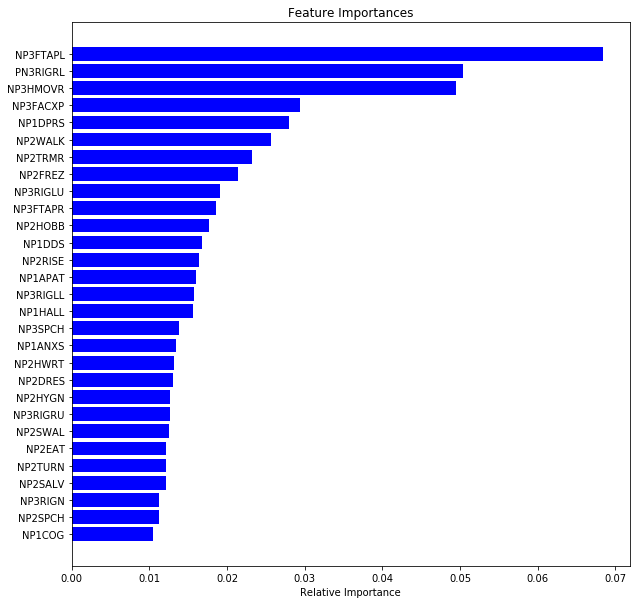

In [21]:
def plot_importantFeatures(clf,X_train,threshold=0.01,figsize=(10,10),color='b'):
    importances=clf.feature_importances_
    importances=importances[importances>=threshold]
    features = X_train.columns
    indices = np.argsort(importances)
    fig = plt.figure(figsize=figsize)
    plt.title('Feature Importances')
    plt.barh(range(len(indices)), importances[indices], color=color, align='center')
    plt.yticks(range(len(indices)), [features[i] for i in indices])
    plt.xlabel('Relative Importance')
    plt.show()

plot_importantFeatures(rfc,X_train)

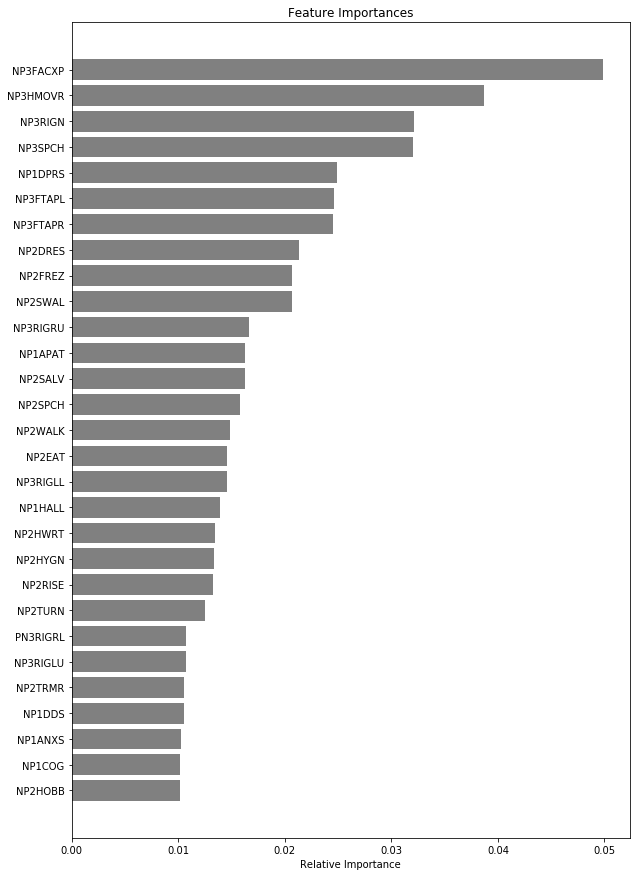

In [22]:
feature_importances_up = pd.DataFrame(rfc_up.feature_importances_,
                                   index = X_train_up.columns,
                                    columns=['importance']).sort_values('importance',ascending=False)
#ImportantFeatures_up=feature_importances_up[feature_importances.values>=0.01]
plot_importantFeatures(rfc_up,X_train_up,figsize=(10,15),color='grey')
RelevantFeatures_up=feature_importances_up[feature_importances_up.values>0]
RelevantFeaturesList_up=list(RelevantFeatures_up.index)

## 4. Evaluation: Calculating, plotting metrics

In [23]:
print("Train-Score-logreg: %.4f, Test-Accuracy-logreg: %.4f" % (logreg.score(X_train, y_train), 
                                                                logreg.score(X_test, y_test)))
print("Train-Score-logreg-up: %.4f, Test-Accuracy-logreg-up: %.4f" % (logreg_up.score(X_train_up, y_train_up), 
                                                                      logreg_up.score(X_test, y_test)))
print("Train-Score-rfc: %.4f, Test-Accuracy-rfc: %.4f" % (rfc.score(X_train, y_train), rfc.score(X_test, y_test)))
print("Train-Score-rfc-up: %.4f, Test-Accuracy-rfc: %.4f" % (rfc_up.score(X_train_up, y_train_up), 
                                                             rfc_up.score(X_test, y_test)))
print("Train-Score-rfc-weighted: %.4f, Test-Accuracy-weighted: %.4f" % (rfc_weighted.score(X_train, y_train), 
                                                             rfc_weighted.score(X_test, y_test)))

print("Train-Score-xgb: %.4f, Test-Accuracy-xgb: %.4f" % (xgb.score(X_train, y_train), 
                                                         xgb.score(X_test, y_test)))
print("Train-Score-xgb-up: %.4f, Test-Accuracy-xgb-up: %.4f" % (xgb_up.score(X_train_up, y_train_up), 
                                                         xgb_up.score(X_test, y_test)))

Train-Score-logreg: 0.9889, Test-Accuracy-logreg: 0.8429
Train-Score-logreg-up: 0.9972, Test-Accuracy-logreg-up: 0.8171
Train-Score-rfc: 1.0000, Test-Accuracy-rfc: 0.8748
Train-Score-rfc-up: 1.0000, Test-Accuracy-rfc: 0.8946
Train-Score-rfc-weighted: 1.0000, Test-Accuracy-weighted: 0.8748
Train-Score-xgb: 0.9880, Test-Accuracy-xgb: 0.8847
Train-Score-xgb-up: 0.9923, Test-Accuracy-xgb-up: 0.8807


### Confusion Matrix

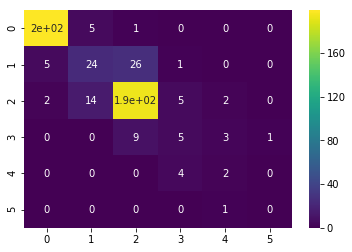

In [24]:
y_pred_logreg=logreg.predict(X_test)
cm_logreg=confusion_matrix(y_test,y_pred_logreg)
cm_logreg_df=pd.DataFrame(cm_logreg,index=[0,1,2,3,4,5],columns=[0,1,2,3,4,5])
import seaborn as sns
sns.heatmap(cm_logreg_df,annot=True,cmap='viridis')

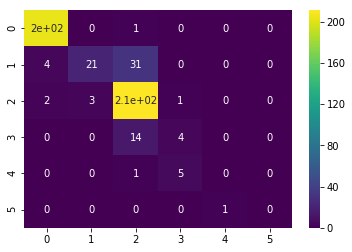

In [25]:
y_pred_rfc=rfc.predict(X_test)
cm_rfc=confusion_matrix(y_test,y_pred_rfc)
cm_rfc_df=pd.DataFrame(cm_rfc,index=[0,1,2,3,4,5],columns=[0,1,2,3,4,5])
sns.heatmap(cm_rfc_df,annot=True,cmap='viridis')

### classification report

In [26]:
from sklearn.metrics import classification_report
report_logreg = classification_report(y_test, 
                      y_pred_logreg)
print(report_logreg)

             precision    recall  f1-score   support

        0.0       0.97      0.97      0.97       205
        1.0       0.56      0.43      0.48        56
        2.0       0.84      0.89      0.87       217
        3.0       0.33      0.28      0.30        18
        4.0       0.25      0.33      0.29         6
        5.0       0.00      0.00      0.00         1

avg / total       0.83      0.84      0.84       503



In [27]:
report_rfc = classification_report(y_test, 
                      y_pred_rfc)
print(report_rfc)

             precision    recall  f1-score   support

        0.0       0.97      1.00      0.98       205
        1.0       0.88      0.38      0.53        56
        2.0       0.82      0.97      0.89       217
        3.0       0.40      0.22      0.29        18
        4.0       0.00      0.00      0.00         6
        5.0       0.00      0.00      0.00         1

avg / total       0.86      0.87      0.85       503



/Users/alicemartin/miniconda3/envs/project/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [28]:
y_pred_rfc_up=rfc_up.predict(X_test)
report_rfc_up = classification_report(y_test, 
                      y_pred_rfc_up)
print(report_rfc_up)

             precision    recall  f1-score   support

        0.0       0.97      0.99      0.98       205
        1.0       0.73      0.68      0.70        56
        2.0       0.89      0.93      0.91       217
        3.0       0.50      0.33      0.40        18
        4.0       0.50      0.17      0.25         6
        5.0       0.00      0.00      0.00         1

avg / total       0.88      0.89      0.89       503



/Users/alicemartin/miniconda3/envs/project/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


## 5. Cross-Validation

In [29]:
from sklearn.cross_validation import LeaveOneOut, StratifiedKFold
from sklearn.model_selection import cross_val_score
#cv_score=cross_val_score(logreg,data,target,cv=5,n_jobs=-1)
#print(cv_score)

# C = 1/lambda, the parameter of the sigmoid function
# lambda = 0.001, 0.005, 0.01, 0.05, ..., 1, 5, 10, 50

In [30]:
#print(cv_score.mean())

In [31]:
cv_score_rfc=cross_val_score(rfc,data,target,cv=5,n_jobs=-1)
print(cv_score_rfc)
print(cv_score_rfc.mean())

[0.82492582 0.8694362  0.85416667 0.82582583 0.83987915]
0.8428467328750393


In [32]:
# data_up & target_up to define. 
cv_score_rfc_up=cross_val_score(rfc_up,data_up,target_up,cv=5,n_jobs=-1)
print(cv_score_rfc_up)
print(cv_score_rfc_up.mean())

[0.96836983 0.98053528 0.98418491 0.98039216 0.99019608]
0.9807356519250036


## 6. Hyperparameter tuning with GridSearchCV

#### Using only the Relevant Features from the feature importance

In [33]:
data_GS=data[RelevantFeaturesList]
data_GS.head()

,DOMSIDE,PRIMDIAG,PDDXDT_diff_days,DFRIGIDP,NP3FACXP,PD_MED_USE,NP3BRADY,PDMEDYN,DFPGDIST,DXBRADY,...,DRMOBJFL,SENRARSP,MCABDS,DFAXRIG,GDSALIVE,CN5RSP,MCAVIGIL,DFFREEZ,MHROW_10,CN7RSP
PATNO,,,,,,,,,,,,,,,,,,,,,
3001,2.0,1.0,1461.0,1.0,2.0,3.0,2.0,1.0,0.0,1.0,...,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
3002,1.0,1.0,1504.5,1.0,2.0,1.0,1.0,1.0,0.0,1.0,...,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
3003,2.0,1.0,1857.0,1.0,2.0,3.0,2.0,1.0,0.0,1.0,...,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
3006,2.0,1.0,333.5,1.0,1.5,3.0,1.0,0.5,0.0,1.0,...,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
3007,2.0,1.0,90.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0


In [34]:
np.mean([estimator.tree_.max_depth for estimator in rfc.estimators_])

17.92

#### data upsampled

In [35]:
data_upsampled=upsampling_NHY(dfAgg)
target_upsampled=data_upsampled.NHY
data_upsampled_GS=data_upsampled[RelevantFeaturesList_up]

5.0    683
4.0    683
3.0    683
2.0    683
1.0    683
0.0    683
Name: NHY, dtype: int64


In [36]:
def grid_search(param_grid, estimator, data, target, cv=3,njobs=-1):
    from sklearn.model_selection import GridSearchCV
    est = estimator
    grid_search=GridSearchCV(est, param_grid,cv=cv)
    grid_search.fit(data,target)
    print("Best estimator:\n{}".format(grid_search.best_estimator_))
    print("Best parameters: {}".format(grid_search.best_params_))
    print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))
    return grid_search


#param_grid_rfc={'n_estimators':[10,15,20],
               #'max_features':[10,50,100],
               #'max_leaf_nodes':[None,25,50,100]}
#grid_search=GridSearchCV(RandomForestClassifier(n_jobs=-1),param_grid_rfc,cv=5)

#### with no upsampling

param_grid_rfc={'n_estimators':[500],
               'max_features':[10,20,30],
               'max_depth':[None,5,15]}
grid_search2=grid_search(param_grid_rfc, estimator=RandomForestClassifier(random_state=0), data=data_GS, target=target)

#grid_search2.cv_results_

param_grid3_rfc={'n_estimators':[500,1000],
               'max_features':[15,20,25,30],
               'max_depth':[None,10,15,20]}
grid_search3=grid_search(param_grid3_rfc, estimator=RandomForestClassifier(random_state=0), data=data_GS, target=target)

#grid_search3.cv_results_

# it seems that the overfitting can be really reduced by playing on max_depth: remove None option
param_grid4_rfc={'n_estimators':[500,1000],
               'max_features':[20,30,40],
               'max_depth':[5,10,15]}
grid_search4=grid_search(param_grid4_rfc, estimator=RandomForestClassifier(random_state=0), data=data_GS, target=target)

#grid_search4.cv_results_

param_grid5_rfc={'n_estimators':[1000],
               'max_features':[5,10,15,20],
               'max_depth':[5,7,10]}
grid_search5=grid_search(param_grid5_rfc, estimator=RandomForestClassifier(random_state=0), data=data_GS, target=target)

#grid_search5.cv_results_

#### with upsampling

param_grid_rfc={'n_estimators':[500],
               'max_features':[10,20,30],
               'max_depth':[None,5,15]}
grid_search2_up=grid_search(param_grid_rfc, estimator=RandomForestClassifier(random_state=0), 
                        data=data_upsampled_GS, 
                         target=target_upsampled)

#grid_search2_up.cv_results_

param_grid3_rfc={'n_estimators':[500,1000],
               'max_features':[15,20,25,30],
               'max_depth':[None,10,15,20]}
grid_search3_up=grid_search(param_grid3_rfc, estimator=RandomForestClassifier(random_state=0), 
                         data=data_upsampled_GS, 
                         target=target_upsampled)

#grid_search3_up.cv_results_

# it seems that the overfitting can be really reduced by playing on max_depth: remove None option
param_grid4_rfc={'n_estimators':[500,1000],
               'max_features':[20,30,40],
               'max_depth':[5,10,15]}
grid_search4_up=grid_search(param_grid4_rfc, estimator=RandomForestClassifier(random_state=0), 
                            data=data_upsampled_GS, 
                            target=target_upsampled)

#grid_search4_up.cv_results_

param_grid5_rfc={'n_estimators':[1000],
               'max_features':[5,10,15,20],
               'max_depth':[5,7,10]}
grid_search5_up=grid_search(param_grid5_rfc, estimator=RandomForestClassifier(random_state=0), 
                            data=data_upsampled_GS, 
                            target=target_upsampled)

#grid_search5_up.cv_results_

In [37]:
#grid_search5_up.cv_results_